### Setup

In [1]:
import re

from functools import partial

import pandas as pd
import numpy as np

import jellyfish
from fuzzywuzzy import fuzz

/Users/mpitlyk/miniconda3/envs/DS3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, 
                            precision_score, recall_score, accuracy_score,
                            roc_curve, roc_auc_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
pd.set_option('max_colwidth', 100)

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

### Functions

In [163]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

In [7]:
def calc_and_plot_p_v_r(labels, decision_function):
    precisions, recalls, thresholds = precision_recall_curve(y_true=labels, 
                                                         probas_pred=results) # decision_function or predict_probas
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [153]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

### Load data

In [8]:
df_full = pd.read_csv('../data/real_data/copd_train.csv', sep='^', header=None, names=['Text', 'COPD'])

In [10]:
df_full['Text2'] = df_full.Text.str.lower()

In [11]:
df__no_dupes = df_full.drop_duplicates().copy().reset_index()

### Fuzzy Matching

In [12]:
to_find = ["COPD", "CHRONIC BRONCHITIS", "EMPHYSEMA", "CHRONIC OBSTRUCTIVE PULMONARY DISEASE"]

In [13]:
def iter_subsequences(it, n):
    """Iterate over sublists in a list of lists."""
    for i in range(len(it) - n + 1):
        yield it[i:i+n]

In [14]:
pat = re.compile(r'\b\w\w+\b')
def tokenize(s):
    """Split string into words tokens."""
    return pat.findall(s)

In [97]:
def fuzzy_match(it, term, func=jellyfish.levenshtein_distance, denom=max):
    results = []
    # Loop over all substrings 
    for sub_it in iter_subsequences(it, len(tokenize(term))):
        sub = ' '.join(sub_it)
        distance = func(sub, term)
        similarity = 1 - (distance / denom(len(sub), len(term)))        
        results.append(similarity)
    if len(results) > 0:
        # Choose highest similarity among all substrings.
        return max(results)
    else:
        return 0

### Damerau-Levenshtein based approach

#### Look at DL approach on each of the four proxy terms

In [98]:
for term in to_find:
    df__no_dupes[term.upper() + '_term'] = df__no_dupes.Text2.map(tokenize).map(partial(fuzzy_match, term=term.lower()))

#### View Precision/Recall vs Threshold plots for each DL/term combination

COPD

In [101]:
precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, 
                                                         probas_pred=df__no_dupes['COPD_term']) # decision_function or predict_probas

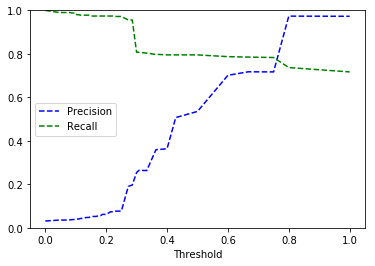

In [102]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Chronic Bronchitis

In [103]:
precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, 
                                                         probas_pred=df__no_dupes['CHRONIC BRONCHITIS_term']) # decision_function or predict_probas

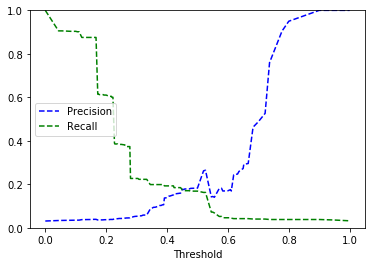

In [104]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Emphysema

In [105]:
precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, 
                                                         probas_pred=df__no_dupes['EMPHYSEMA_term']) # decision_function or predict_probas

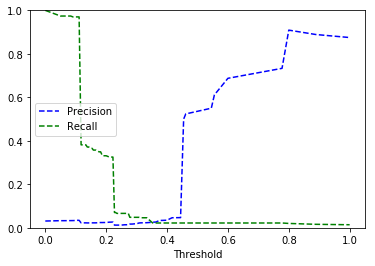

In [106]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Chronic Obstructive Pulmonary Disease

In [107]:
precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, 
                                                         probas_pred=df__no_dupes['CHRONIC OBSTRUCTIVE PULMONARY DISEASE_term']) # decision_function or predict_probas

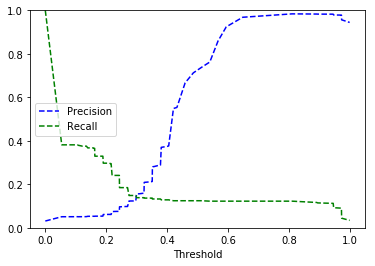

In [108]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### FuzzyWuzzy

#### Helper functions

In [186]:
def plot_precision_recall_vs_threshold_subplots(ax, precision, recalls, thresholds, title=''):
    """Helper function to plot multiple subplots."""
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax.plot(thresholds, recalls[:-1], "g--", label="Recall")
    ax.set(title=title)
    ax.legend(loc="center left")
    ax.set_ylim([0, 1])

In [243]:
def fuzzy(x, func):
    return max(func(x, term.lower()) for term in to_find) / 100

In [231]:
def fuzzy_match_all(x):
    return max(fuzzy_match(x, term.lower()) for term in to_find)

#### Look at each of the four fuzzywuzzy methods across the four proxy terms

In [308]:
all_results = {}
for col, func in enumerate([fuzz.ratio, fuzz.partial_ratio, fuzz.partial_token_sort_ratio, fuzz.partial_token_set_ratio]):
    for row, term in enumerate(to_find):
        results = df__no_dupes.Text2.map(lambda x: func(x, term.lower()))
        all_results[(func.__name__, term)] = results

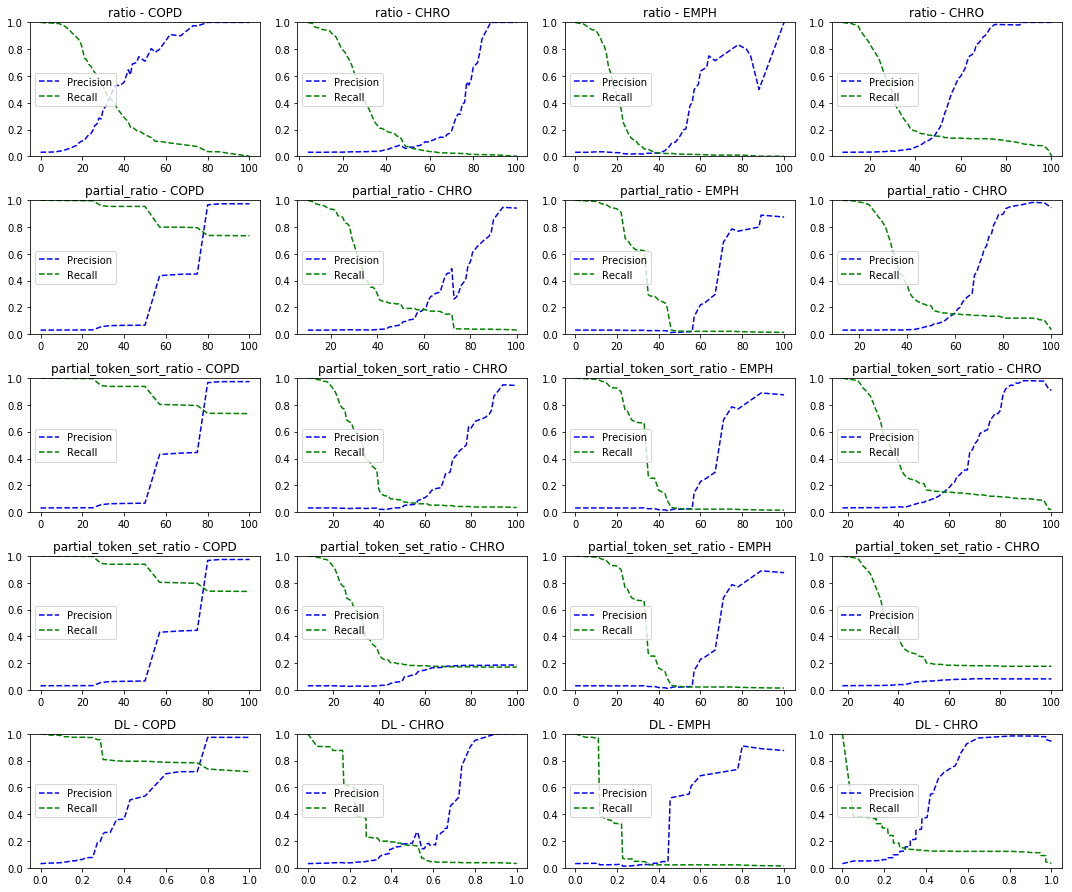

In [217]:
n_rows = 4
fig, axes = plt.subplots(n_rows + 1, 4, figsize=(15, 5*2.5))
for row, func in enumerate([fuzz.ratio, fuzz.partial_ratio, fuzz.partial_token_sort_ratio, fuzz.partial_token_set_ratio]):
    for col, term in enumerate(to_find):
        results = all_results[(func.__name__, term)]
        precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, probas_pred=results)
        plot_precision_recall_vs_threshold_subplots(axes[row, col], precisions, recalls, thresholds, f'{func.__name__} - {term[:4]}')

for col, term in enumerate(to_find):
    precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, probas_pred=df__no_dupes[f'{term}_term'])
    plot_precision_recall_vs_threshold_subplots(axes[n_rows, col], precisions, recalls, thresholds, f'DL - {term[:4]}')

plt.tight_layout()

#### Compute results for each method using max score across proxy terms

In [268]:
names_mapping = {'DL': 'Damerau-Levenshtein', 'ratio': 'Ratio', 'partial_ratio': 'Partial Ratio', 
                'partial_token_sort_ratio': 'Partial Token Sort Ratio', 'partial_token_set_ratio':'Partial Token Set Ratio'}

fuzzy_funcs = [fuzz.ratio, fuzz.partial_ratio, fuzz.partial_token_sort_ratio, fuzz.partial_token_set_ratio]

In [315]:
# DL method taking max score across all terms for each data point
df__no_dupes['DL'] = df__no_dupes.Text2.map(tokenize).map(fuzzy_match_all)

# Each fuzzy method taking max socre across all terms for each data point
for func in fuzzy_funcs:
    df__no_dupes[func.__name__] = df__no_dupes.Text2.map(partial(fuzzy, func=func))

,DL,ratio,partial_ratio,partial_token_sort_ratio,partial_token_set_ratio
count,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000
mean,0.286783,0.338650,0.480938,0.478982,0.506983
std,0.163148,0.101245,0.132860,0.130536,0.180792
min,0.000000,0.000000,0.000000,0.170000,0.170000
25%,0.222222,0.270000,0.400000,0.400000,0.400000
50%,0.250000,0.320000,0.500000,0.500000,0.500000
75%,0.333333,0.380000,0.500000,0.500000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### Plot results

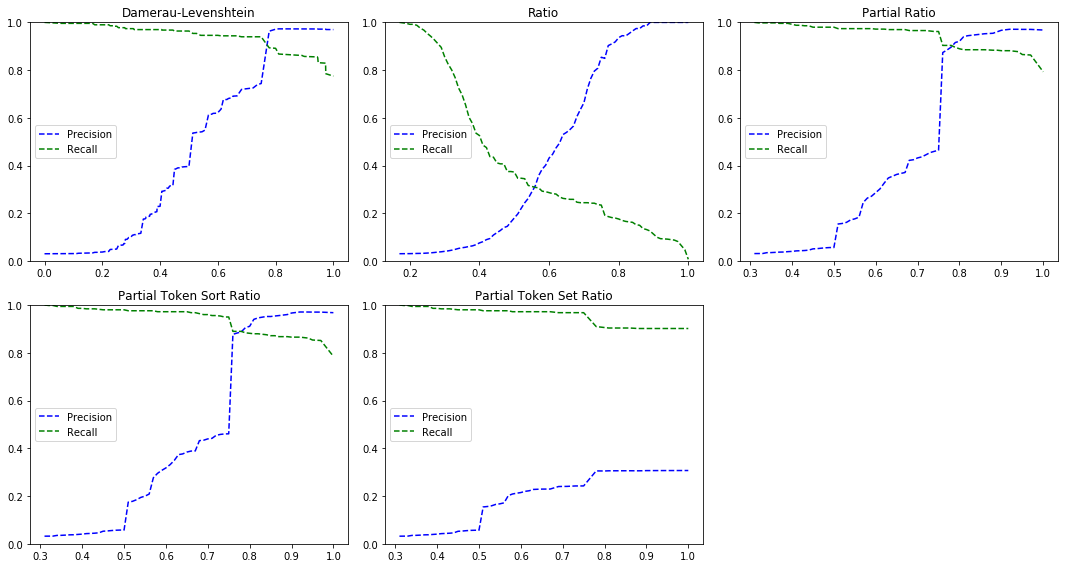

In [270]:
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))

for idx, f in enumerate(['DL'] + [f.__name__ for f in fuzzy_funcs]):
    row = int(idx / n_cols)
    col = idx % n_cols
    precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, probas_pred=df__no_dupes[f])
    plot_precision_recall_vs_threshold_subplots(axes[row, col], precisions, recalls, thresholds, names_mapping[f])
    
axes[1][2].axis('off')

plt.tight_layout()
plt.savefig('fuzzy_match.png')

#### Pick thresholds

These are the thresholds that will be used on the test data set.

In [305]:
new_thresholds = {'DL': .74,
                 'ratio': .55,
                 'partial_ratio': .78,
                 'partial_token_sort_ratio': .77,
                 'partial_token_set_ratio': .5}

In [306]:
for f in ['DL'] + [f.__name__ for f in fuzzy_funcs]:
    print(f)

    accuracy = str(accuracy_score(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f])))[:5]
    recall = str(recall_score(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f])))[:5]
    precision =  str(precision_score(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f])))[:5]
    tn, fp, fn, tp = confusion_matrix(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f])).ravel()
    cm = confusion_matrix(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f]))
    print(f'{new_thresholds[f]}\t{accuracy}\t{precision}\t{recall}\t{fn}\t{fp}')
    print(cm)
    print('---')

DL
0.74	0.988	0.744	0.939	30	161
[[15329   161]
 [   30   468]]
---
ratio
0.55	0.957	0.314	0.309	344	336
[[15154   336]
 [  344   154]]
---
partial_ratio
0.78	0.994	0.915	0.895	52	41
[[15449    41]
 [   52   446]]
---
partial_token_sort_ratio
0.77	0.993	0.887	0.889	55	56
[[15434    56]
 [   55   443]]
---
partial_token_set_ratio
0.5	0.832	0.154	0.975	12	2663
[[12827  2663]
 [   12   486]]
---


In [256]:
for f in ['DL'] + [f.__name__ for f in fuzzy_funcs]:
    print(f)
    print('accuracy:  ' + str(accuracy_score(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f]))))
    print('recall:    ' + str(recall_score(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f]))))
    print('precision: ' + str(precision_score(df__no_dupes.COPD, df__no_dupes[f].map(lambda n: n > new_thresholds[f]))))
    print('---\n')

DL
accuracy:  0.9951213410057543
recall:    0.8674698795180723
precision: 0.972972972972973
---

ratio
accuracy:  0.9574681010758068
recall:    0.3092369477911647
precision: 0.3142857142857143
---

partial_ratio
accuracy:  0.9941831373530148
recall:    0.8955823293172691
precision: 0.9158110882956879
---

partial_token_sort_ratio
accuracy:  0.9928696522391793
recall:    0.8895582329317269
precision: 0.8824701195219123
---

partial_token_set_ratio
accuracy:  0.8326870152614461
recall:    0.9759036144578314
precision: 0.15433470943156558
---



In [304]:
print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP')
for cutoff in np.linspace(0, 1, num=20):
    y_train_pred = (df__no_dupes['partial_token_set_ratio'] > cutoff)
    print('{:.3f}'.format(cutoff), end='\t')
    print('{:.3f}'.format(accuracy_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(precision_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(recall_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    tn, fp, fn, tp = confusion_matrix(df__no_dupes.COPD, y_train_pred).ravel()
    print(sum(y_train_pred), end='\t\t')
    print(fp, end='\t')
    print(fn, end='\t')
    print(tp)

cutoff	acc	prec	recall	pos_count	FP	FN	TP
0.000	0.031	0.031	1.000	15988		15490	0	498
0.053	0.031	0.031	1.000	15988		15490	0	498
0.105	0.031	0.031	1.000	15988		15490	0	498
0.158	0.031	0.031	1.000	15988		15490	0	498
0.211	0.031	0.031	1.000	15984		15486	0	498
0.263	0.037	0.031	1.000	15896		15398	0	498
0.316	0.062	0.032	0.998	15497		15000	1	497
0.368	0.206	0.038	0.994	13190		12695	3	495
0.421	0.339	0.044	0.984	11052		10562	8	490
0.474	0.487	0.056	0.980	8684		8196	10	488
0.526	0.839	0.159	0.976	3055		2569	12	486
0.579	0.884	0.209	0.972	2321		1837	14	484
0.632	0.897	0.228	0.972	2119		1635	14	484
0.684	0.903	0.240	0.968	2010		1528	16	482
0.737	0.905	0.242	0.968	1989		1507	16	482
0.789	0.933	0.305	0.906	1479		1028	47	451
0.842	0.933	0.306	0.904	1471		1021	48	450
0.895	0.933	0.306	0.902	1465		1016	49	449
0.947	0.934	0.307	0.902	1463		1014	49	449
1.000	0.969	0.000	0.000	0		0	498	0


/Users/mpitlyk/miniconda3/envs/DS3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [301]:
print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP')
for cutoff in np.linspace(.74, .78, num=20):
    y_train_pred = (df__no_dupes['partial_token_sort_ratio'] > cutoff)
    print('{:.3f}'.format(cutoff), end='\t')
    print('{:.3f}'.format(accuracy_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(precision_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(recall_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    tn, fp, fn, tp = confusion_matrix(df__no_dupes.COPD, y_train_pred).ravel()
    print(sum(y_train_pred), end='\t\t')
    print(fp, end='\t')
    print(fn, end='\t')
    print(tp)

cutoff	acc	prec	recall	pos_count	FP	FN	TP
0.740	0.964	0.461	0.950	1027		554	25	473
0.742	0.964	0.461	0.950	1027		554	25	473
0.744	0.964	0.461	0.950	1027		554	25	473
0.746	0.964	0.461	0.950	1027		554	25	473
0.748	0.964	0.461	0.950	1027		554	25	473
0.751	0.993	0.877	0.890	505		62	55	443
0.753	0.993	0.877	0.890	505		62	55	443
0.755	0.993	0.877	0.890	505		62	55	443
0.757	0.993	0.877	0.890	505		62	55	443
0.759	0.993	0.877	0.890	505		62	55	443
0.761	0.993	0.882	0.890	502		59	55	443
0.763	0.993	0.882	0.890	502		59	55	443
0.765	0.993	0.882	0.890	502		59	55	443
0.767	0.993	0.882	0.890	502		59	55	443
0.769	0.993	0.882	0.890	502		59	55	443
0.772	0.993	0.888	0.890	499		56	55	443
0.774	0.993	0.888	0.890	499		56	55	443
0.776	0.993	0.888	0.890	499		56	55	443
0.778	0.993	0.888	0.890	499		56	55	443
0.780	0.993	0.905	0.884	486		46	58	440


In [288]:
print('cutoff\tacc\tprec\trecall\tpos_count')
for cutoff in np.linspace(0.74, .76, num=20):
    y_train_pred = (df__no_dupes['partial_ratio'] > cutoff)
    print('{:.3f}'.format(cutoff), end='\t')
    print('{:.3f}'.format(accuracy_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(precision_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(recall_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print(sum(y_train_pred))

cutoff	acc	prec	recall	pos_count
0.740	0.964	0.465	0.962	1031
0.741	0.964	0.465	0.962	1031
0.742	0.964	0.465	0.962	1031
0.743	0.964	0.465	0.962	1031
0.744	0.964	0.465	0.962	1031
0.745	0.964	0.465	0.962	1031
0.746	0.964	0.465	0.962	1031
0.747	0.964	0.465	0.962	1031
0.748	0.964	0.465	0.962	1031
0.749	0.964	0.465	0.962	1031
0.751	0.993	0.874	0.904	515
0.752	0.993	0.874	0.904	515
0.753	0.993	0.874	0.904	515
0.754	0.993	0.874	0.904	515
0.755	0.993	0.874	0.904	515
0.756	0.993	0.874	0.904	515
0.757	0.993	0.874	0.904	515
0.758	0.993	0.874	0.904	515
0.759	0.993	0.874	0.904	515
0.760	0.993	0.884	0.904	509


In [288]:
print('cutoff\tacc\tprec\trecall\tpos_count')
for cutoff in np.linspace(0.74, .76, num=20):
    y_train_pred = (df__no_dupes['partial_ratio'] > cutoff)
    print('{:.3f}'.format(cutoff), end='\t')
    print('{:.3f}'.format(accuracy_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(precision_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print('{:.3f}'.format(recall_score(df__no_dupes.COPD, y_train_pred)), end='\t')
    print(sum(y_train_pred))

cutoff	acc	prec	recall	pos_count
0.740	0.964	0.465	0.962	1031
0.741	0.964	0.465	0.962	1031
0.742	0.964	0.465	0.962	1031
0.743	0.964	0.465	0.962	1031
0.744	0.964	0.465	0.962	1031
0.745	0.964	0.465	0.962	1031
0.746	0.964	0.465	0.962	1031
0.747	0.964	0.465	0.962	1031
0.748	0.964	0.465	0.962	1031
0.749	0.964	0.465	0.962	1031
0.751	0.993	0.874	0.904	515
0.752	0.993	0.874	0.904	515
0.753	0.993	0.874	0.904	515
0.754	0.993	0.874	0.904	515
0.755	0.993	0.874	0.904	515
0.756	0.993	0.874	0.904	515
0.757	0.993	0.874	0.904	515
0.758	0.993	0.874	0.904	515
0.759	0.993	0.874	0.904	515
0.760	0.993	0.884	0.904	509


### Test dataset

In [309]:
df_full_test = pd.read_csv('../data/real_data/copd_test.csv', sep='^', header=None, names=['Text', 'COPD'])

# Lowercase data
df_full_test['Text2'] = df_full_test.Text.str.lower()

# Drop duplicates
df__no_dupes_test = df_full_test.drop_duplicates().copy().reset_index()

#### Run methods on test data

In [318]:
# DL method taking max score across all terms for each data point
df__no_dupes_test['DL'] = df__no_dupes_test.Text2.map(tokenize).map(fuzzy_match_all)

# Each fuzzy method taking max socre across all terms for each data point
for func in fuzzy_funcs:
    df__no_dupes_test[func.__name__] = df__no_dupes_test.Text2.map(partial(fuzzy, func=func))

In [320]:
y_test_true = df__no_dupes_test.COPD

for f in ['DL'] + [f.__name__ for f in fuzzy_funcs]:
    y_test_pred_classes = df__no_dupes_test[f].map(lambda n: n > new_thresholds[f])
    print(f)
    print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
    print('{:.3f}'.format(new_thresholds[f]), end='\t')
    print('{:.3f}'.format(accuracy_score(y_test_true, y_test_pred_classes)), end='\t')
    print('{:.3f}'.format(precision_score(y_test_true, y_test_pred_classes)), end='\t')
    print('{:.3f}'.format(recall_score(y_test_true, y_test_pred_classes)), end='\t')
    tn, fp, fn, tp = confusion_matrix(y_test_true, y_test_pred_classes).ravel()
    print(sum(y_test_pred_classes), end='\t\t')
    print(fp, end='\t')
    print(fn, end='\t')
    print(tp, end='\t')
    print(tn)

DL
cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.740	0.988	0.763	0.908	232		55	18	177	5893
ratio
cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.550	0.958	0.357	0.385	210		135	120	75	5813
partial_ratio
cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.780	0.993	0.901	0.882	191		19	23	172	5929
partial_token_sort_ratio
cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.770	0.993	0.883	0.887	196		23	22	173	5925
partial_token_set_ratio
cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.500	0.834	0.159	0.990	1211		1018	2	193	4930
